In [1]:
suppressWarnings(suppressPackageStartupMessages({
  library(tidyverse)
    library(data.table)
    library(EvolutionaryGames)
    library(ggthemes)
    library(latex2exp)
    library(ggtext)
    library(progress)
}))

In [2]:
duplicate_dynamic_xy<-function(y,x,M,beta1,beta2,d,N,c,l){
  
  #-----参数解释说明------#
  # #N个个体
  # N<-4
  # #M资源 c(5,15,25)
  # M<-5
  
  # y 整体内卷比例
  # x 整体躺平比例
  
  # #内卷相对躺平的效用
  # beta1<-4
  # #合作相对躺平的效用
  # beta2<-2
  
  # #more effort的成本
  # d<-4
  # #less effort的成本
  # c<-1
  # #躺平的成本
  # l<-0.5
  #-----------------------#
  
  Pc<-0
  Pd<-0
  Pl<-0 
  for (Nd in 0:(N-1)){ 
    for (Nl in 0:(N-1-Nd)){
      Nc <- N-1-Nd-Nl
      pai_d <- beta1*d*M/(beta1*(Nd+1)*d +beta2*Nc*c     +Nl*l)-d 
      pai_c <- beta2*c*M/(beta1*Nd*d     +beta2*(Nc+1)*c +Nl*l)-c          
      pai_l <-       l*M/(beta1*Nd*d     +beta2*Nc*c     +(Nl+1)*l)-l  
      Pd <- Pd + choose(N-1,Nd)*choose(N-1-Nd,Nl)*y^Nd*(1-x-y)^Nc*x^Nl*pai_d
      Pc <- Pc + choose(N-1,Nd)*choose(N-1-Nd,Nl)*y^Nd*(1-x-y)^Nc*x^Nl*pai_c
      Pl <- Pl + choose(N-1,Nd)*choose(N-1-Nd,Nl)*y^Nd*(1-x-y)^Nc*x^Nl*pai_l
    }
  }
  
  R_ <- y*Pd+x*Pl+(1-x-y)*Pc  ##均值
  y. <- y*(Pd-R_)
  x. <- x*(Pl-R_)
  
  result<-data.frame(y=y,x=x,M=M,beta1=beta1,beta2=beta2,d=d,N=N,c=c,l=l,y.=y.,x.=x.)
  return(result)
}

# 原文三点结论：一一验证
# 1.更充足的资源会促进内卷
# 2.增加更努力的相对效用会放大内卷
# 3.增加内卷的成本会在一定参数范围内放大内卷，但最终会抑制内卷

# 能否找到“卷不动，躺不平”的“点”？
# 如何在“卷”和“躺”中找平衡？
# “合作”实质是一中不内卷、也不躺平的一种状态，用什么词描述更准确？45度？斜垮？漂？划水？摸鱼？
# 思路：合作的成本c远离d是一种“卷不动”的现象；合作的成本c趋近l但又不等于l来表示“躺不平”

In [65]:
#----------------------------------------------#
#-----1.1当躺平人数一定时，内卷人数的稳定点----#
#----------------------------------------------#

#x+y<=1
data<-data.frame()
pb <- progress_bar$new(format = "  完成百分比 [:bar] :percent 执行时间 :elapsed:elapsedfull",total = 101, clear = FALSE, width= 60)
for(y in seq(0,1,0.01)){
  pb$tick()
  for(x in seq(0,1-y,0.01)){
    temp<-duplicate_dynamic_xy(y,x,M=100,beta1=4,beta2=2,d=4,N=50,c=1,l=0.5)
    data<-rbind(data,temp)
  }
}


data1<-data %>% 
  mutate(y=round(y,digits=2)) %>% #排序有问题，debug是浮点数的问题#第495行
  mutate(x=round(x,digits=2)) %>%
  arrange(x,y) %>% 
  data.table() %>% 
  .[,y1:=c(y.[-1],0),by=x] %>% 
  mutate(y0=y.*y1) %>% 
  data.table() %>% 
  .[,ystar:=y[y0<0]-0.005,by=x] %>% 
  mutate(ystar=ifelse(is.na(ystar),0,ystar)) %>% #好多NA的问题，是无0,要设置为o
  subset(!is.na(ystar))


  完成百分比 [>---------------------------]   2% 执行时间  1s00:00:01

  完成百分比 [>---------------------------]   3% 执行时间  2s00:00:02

  完成百分比 [>---------------------------]   4% 执行时间  3s00:00:03

  完成百分比 [>---------------------------]   5% 执行时间  4s00:00:03

  完成百分比 [=>--------------------------]   6% 执行时间  5s00:00:04

  完成百分比 [=>--------------------------]   7% 执行时间  6s00:00:05

  完成百分比 [=>--------------------------]   8% 执行时间  7s00:00:06

  完成百分比 [=>--------------------------]   9% 执行时间  7s00:00:07

  完成百分比 [==>-------------------------]  10% 执行时间  8s00:00:07

  完成百分比 [==>-------------------------]  11% 执行时间  9s00:00:08

  完成百分比 [==>-------------------------]  12% 执行时间  9s00:00:09

  完成百分比 [===>------------------------]  13% 执行时间 10s00:00:09

  完成百分比 [===>------------------------]  14% 执行时间 10s00:00:10

  完成百分比 [===>------------------------]  15% 执行时间 11s00:00:10

  完成百分比 [===>------------------------]  16% 执行时间 11s00:00:11

  完成百分比 [====>-----------------------]  17% 执行时间 12s00:00:11

  完成百分比

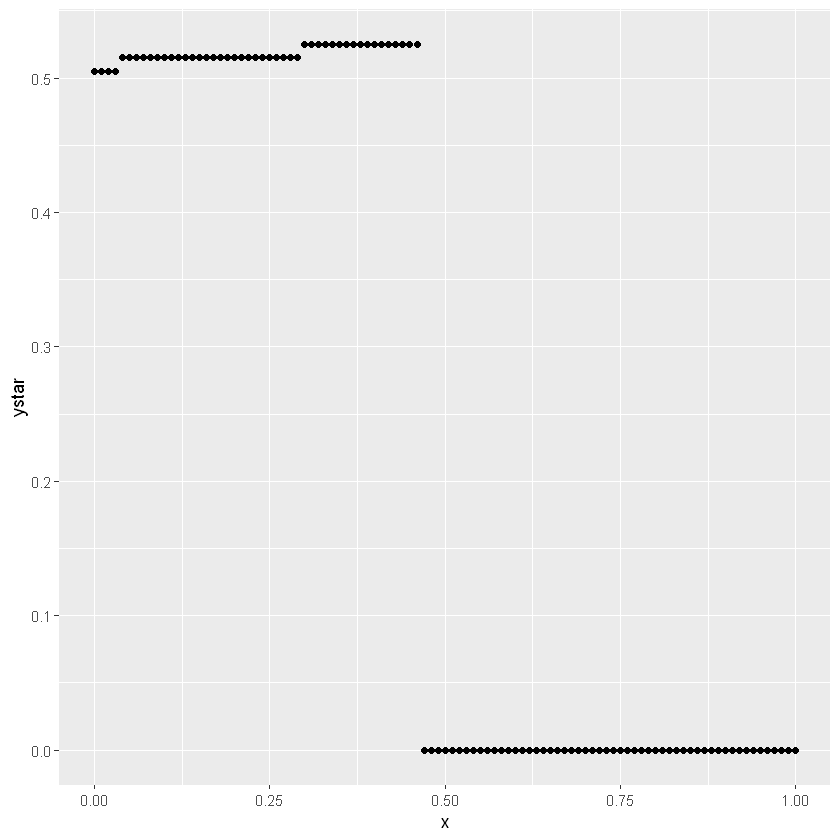

In [66]:
#ystar随x是如何变化的？
ggplot(data1,aes(x=x,y=ystar))+
  geom_point()

#如何解释？

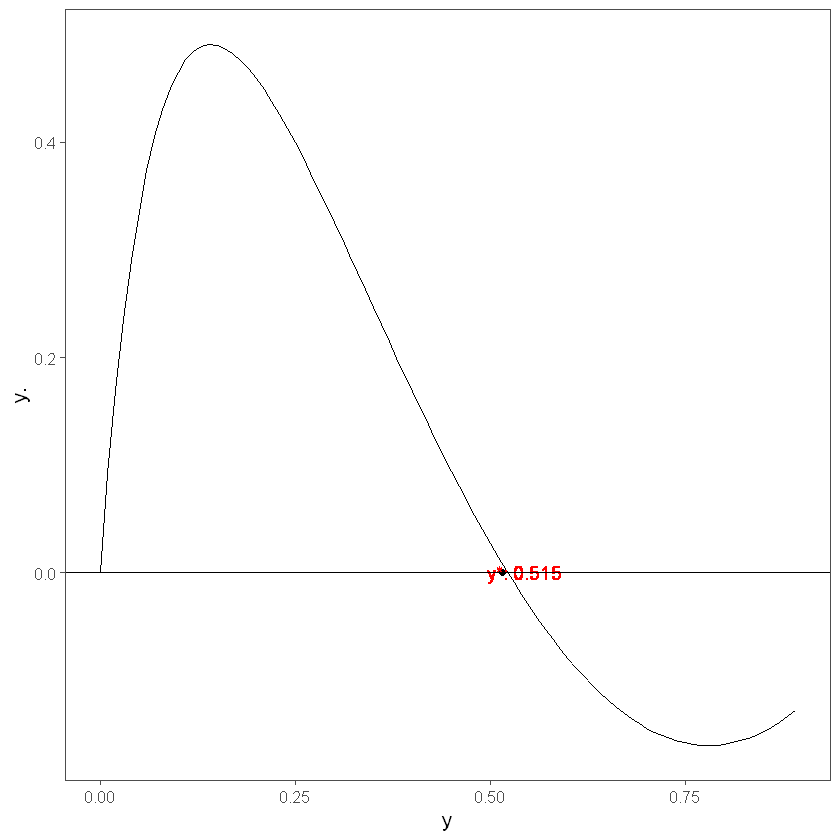

In [67]:
#当x=0.1时
df<-data %>% 
  subset(x==0.1)%>% 
  mutate(y1=c(y.[-1],1)) %>% 
  mutate(y0=y*y1)#通过前一项与后一项相乘是否小于0，来获取临界点ystar

ystar<-ifelse(sum(df$y[df$y0<0])==0,0,df$y[df$y0<0]-0.005)

ggplot(df,aes(x=y,y=y.))+
  geom_line(color="black",size=0.3)+
  theme_few() +
  geom_point(aes(x=ystar,y=0))+
  geom_text(aes(x=ystar,y=0),label=paste("y*:",ystar),size=4,nudge_y = 0.001,nudge_x = 0.03,color="red")+
  geom_hline(aes(yintercept = 0),size=0.3)+
  labs(x = "y", y = "y.")

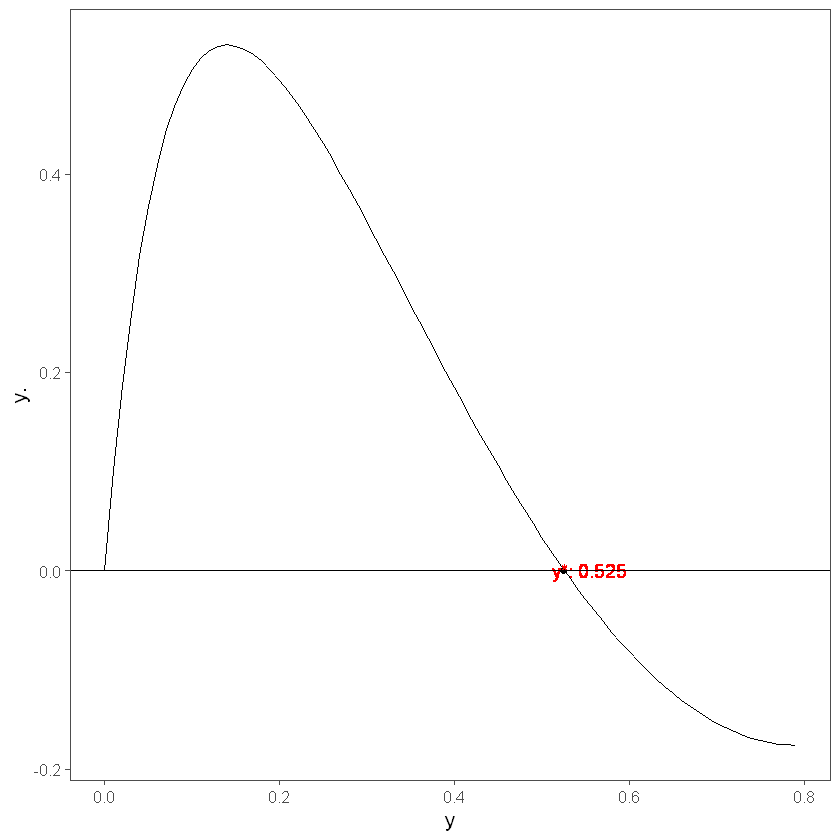

In [68]:
#当x=0.2时
df<-data %>% 
  subset(x==0.2)%>% 
  mutate(y1=c(y.[-1],1)) %>% 
  mutate(y0=y*y1)#通过前一项与后一项相乘是否小于0，来获取临界点ystar

ystar<-ifelse(sum(df$y[df$y0<0])==0,0,df$y[df$y0<0]+0.005)

ggplot(df,aes(x=y,y=y.))+
  geom_line(color="black",size=0.3)+
  theme_few() +
  geom_point(aes(x=ystar,y=0))+
  geom_text(aes(x=ystar,y=0),label=paste("y*:",ystar),size=4,nudge_y = 0.001,nudge_x = 0.03,color="red")+
  geom_hline(aes(yintercept = 0),size=0.3)+
  labs(x = "y", y = "y.")

In [69]:
data1

y,x,M,beta1,beta2,d,N,c,l,y.,x.,y1,y0,ystar
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00,0,100,4,2,4,50,1,0.5,0.00000000,0,0.08347045,0.00000000,0.505
0.01,0,100,4,2,4,50,1,0.5,0.08347045,0,0.15443857,0.01289106,0.505
0.02,0,100,4,2,4,50,1,0.5,0.15443857,0,0.21457544,0.03313872,0.505
0.03,0,100,4,2,4,50,1,0.5,0.21457544,0,0.26530240,0.05692738,0.505
0.04,0,100,4,2,4,50,1,0.5,0.26530240,0,0.30783254,0.08166871,0.505
0.05,0,100,4,2,4,50,1,0.5,0.30783254,0,0.34320484,0.10564962,0.505
0.06,0,100,4,2,4,50,1,0.5,0.34320484,0,0.37231215,0.12777933,0.505
0.07,0,100,4,2,4,50,1,0.5,0.37231215,0,0.39592441,0.14740747,0.505
0.08,0,100,4,2,4,50,1,0.5,0.39592441,0,0.41470771,0.16419290,0.505


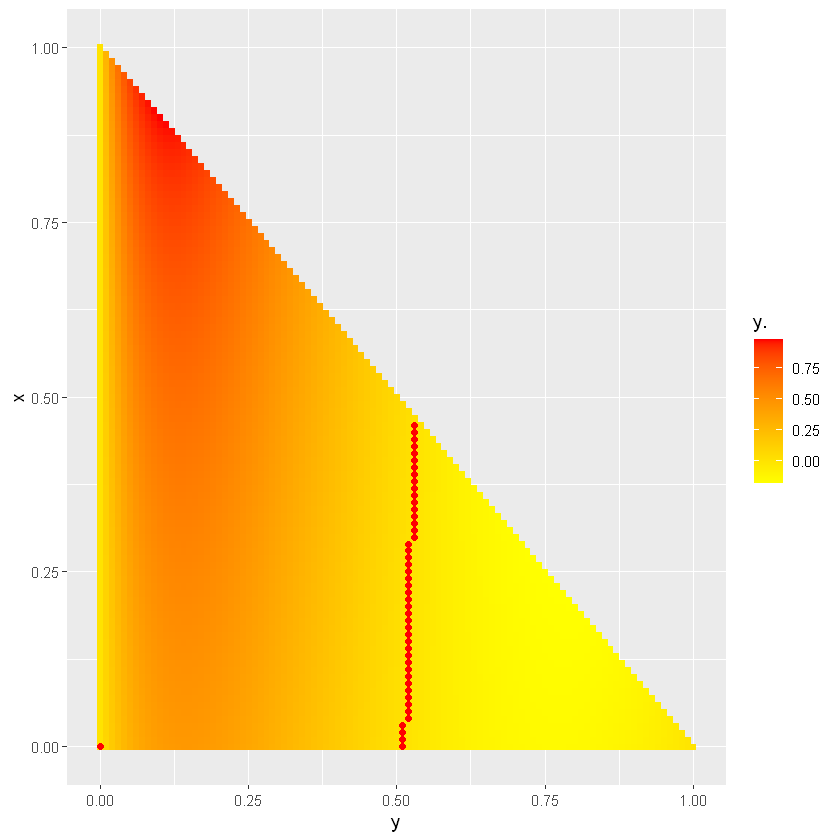

In [70]:
#x与y对ystar的影响？
#.x,y, fill=y.  然后把y.=0的点标记红色
data2<-data1 %>% 
  subset(y0<0) %>% 
  dplyr::select(y,x)

data3<-data1 %>% 
  mutate(x2=c(data2$x,rep(0,nrow(data1)-nrow(data2)))) %>% 
  mutate(y2=c(data2$y,rep(0,nrow(data1)-nrow(data2))))

ggplot(data3,aes(x=y,y=x))+
  geom_raster(aes(fill=y.))+
  scale_fill_gradient(high = "red", low ="yellow")+ #解决灰块问题
  geom_point(aes(x=y2,y=x2),color="red")

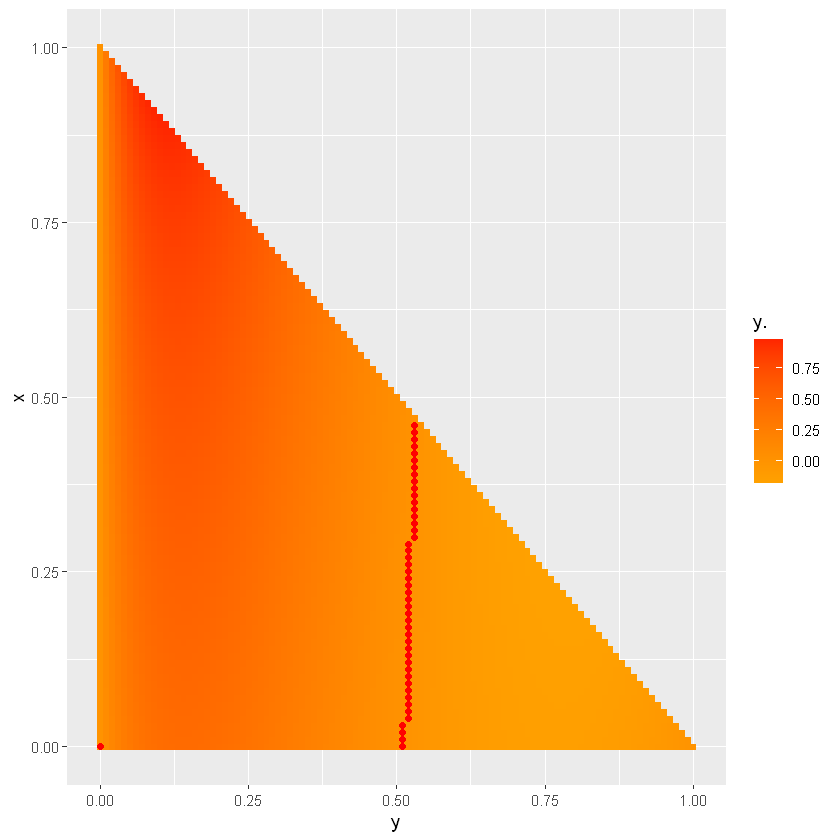

In [54]:
#x与y对ystar的影响？
#.x,y, fill=y.  然后把y.=0的点标记红色
data2<-data1 %>% 
  subset(y0<0) %>% 
  dplyr::select(y,x)

data3<-data1 %>% 
  mutate(x2=c(data2$x,rep(0,nrow(data1)-nrow(data2)))) %>% 
  mutate(y2=c(data2$y,rep(0,nrow(data1)-nrow(data2))))

ggplot(data3,aes(x=y,y=x))+
  geom_raster(aes(fill=y.))+
  scale_fill_gradientn(values = c(round(min(data3$y.),digits = 2)-0.1,0,round(max(data3$y.),digits = 2)+0.1),
                       colors = c('yellow','red'))+
  geom_point(aes(x=y2,y=x2),color="red")

#左上角有点异常点，什么原因？
#如何配色更适合凸显0的分界线？
#如何解释？

In [44]:
max(data3$y.)

[1] 0.9816108

In [35]:
min(data3$y.)

[1] -0.1788173

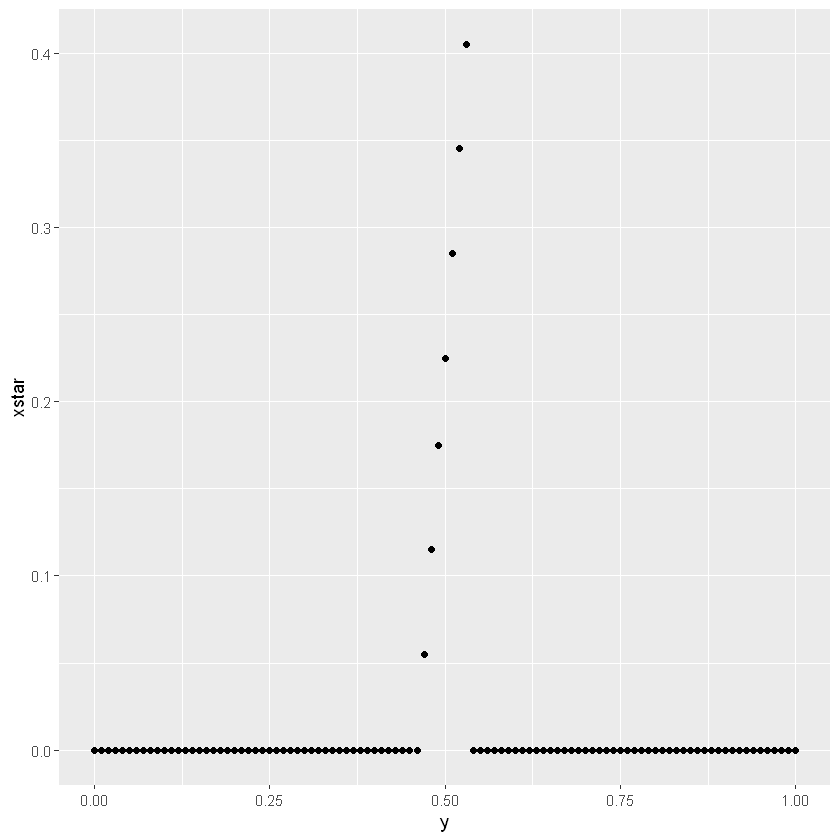

In [71]:
#----------------------------------------------#
#--------1.2内卷人数比例对躺平人数的影响-------#
#----------------------------------------------#

data1<-data %>% 
  mutate(y=round(y,digits=2)) %>% #排序有问题，debug是浮点数的问题#第495行
  mutate(x=round(x,digits=2)) %>%
  arrange(y,x) %>% 
  data.table() %>% 
  .[,x1:=c(x.[-1],0),by=y] %>% 
  mutate(x0=x.*x1) %>% 
  data.table() %>% 
  .[,xstar:=x[x0<0]-0.005,by=y] %>% 
  mutate(xstar=ifelse(is.na(xstar),0,xstar)) %>% #好多NA的问题，是无0,要设置为o
  subset(!is.na(ystar))

#ystar随x是如何变化的？
ggplot(data1,aes(x=y,y=xstar))+
  geom_point()

#如何解释？

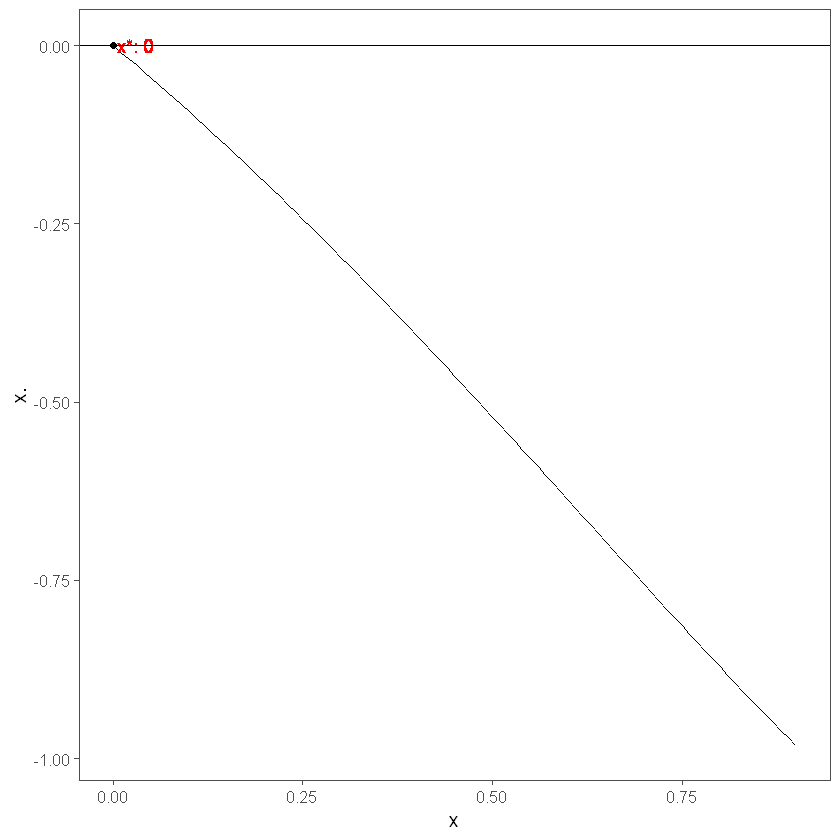

In [72]:
#当y=0.1时
df<-data %>% 
  subset(y==0.1)%>% 
  mutate(x1=c(x.[-1],0)) %>%                                                                          
  mutate(x0=x.*x1)#通过前一项与后一项相乘是否小于0，来获取临界点ystar

xstar<-ifelse(sum(df$x[df$x0<0])==0,0,df$x[df$x0<0]+0.005)

ggplot(df,aes(x=x,y=x.))+
  geom_line(color="black",size=0.3)+
  theme_few() +
  geom_point(aes(x=xstar,y=0))+
  geom_text(aes(x=xstar,y=0),label=paste("x*:",xstar),size=4,nudge_y = 0.001,nudge_x = 0.03,color="red")+
  geom_hline(aes(yintercept = 0),size=0.3)+
  labs(x = "x", y = "x.")

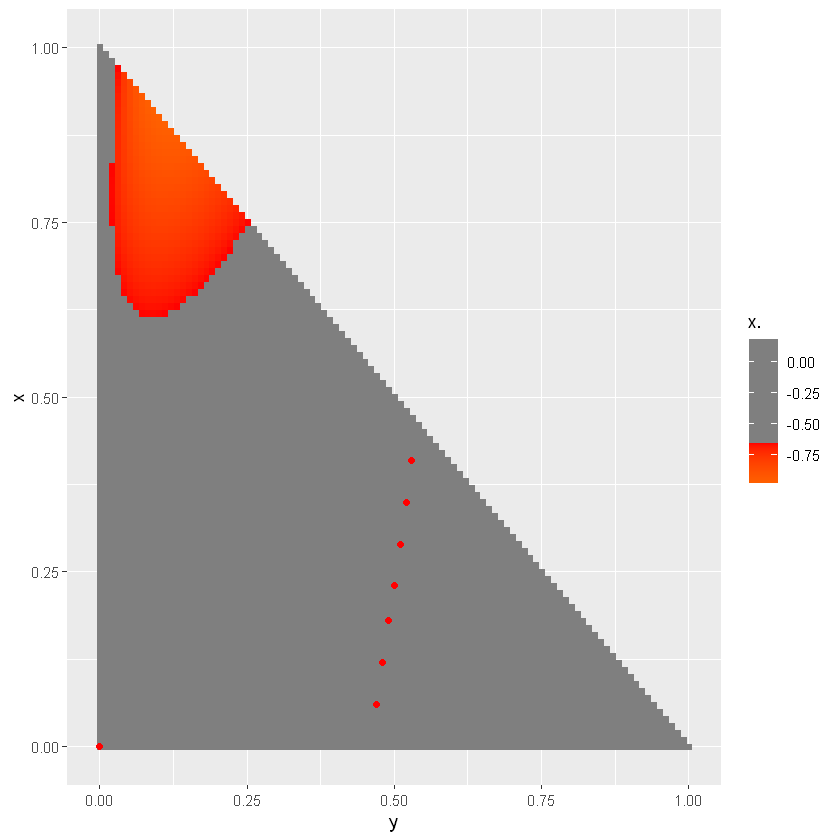

In [63]:
#x与y对xstar的影响？
#.x,y, fill=y.  然后把y.=0的点标记红色
data2<-data1 %>% 
  subset(x0<0) %>% 
  dplyr::select(y,x)

data3<-data1 %>% 
  mutate(x2=c(data2$x,rep(0,nrow(data1)-nrow(data2)))) %>% 
  mutate(y2=c(data2$y,rep(0,nrow(data1)-nrow(data2))))

ggplot(data3,aes(x=y,y=x))+
  scale_fill_gradientn(values = c(round(min(data3$x.),digits = 2)-0.1,round(max(data3$x.),digits = 2)+0.1),
                       colors = c('yellow','red'))+
  geom_raster(aes(fill=x.))+
  geom_point(aes(x=y2,y=x2),color="red")

#大片异常点，什么原因？
#如何配色更适合凸显0的分界线？
#如何解释？

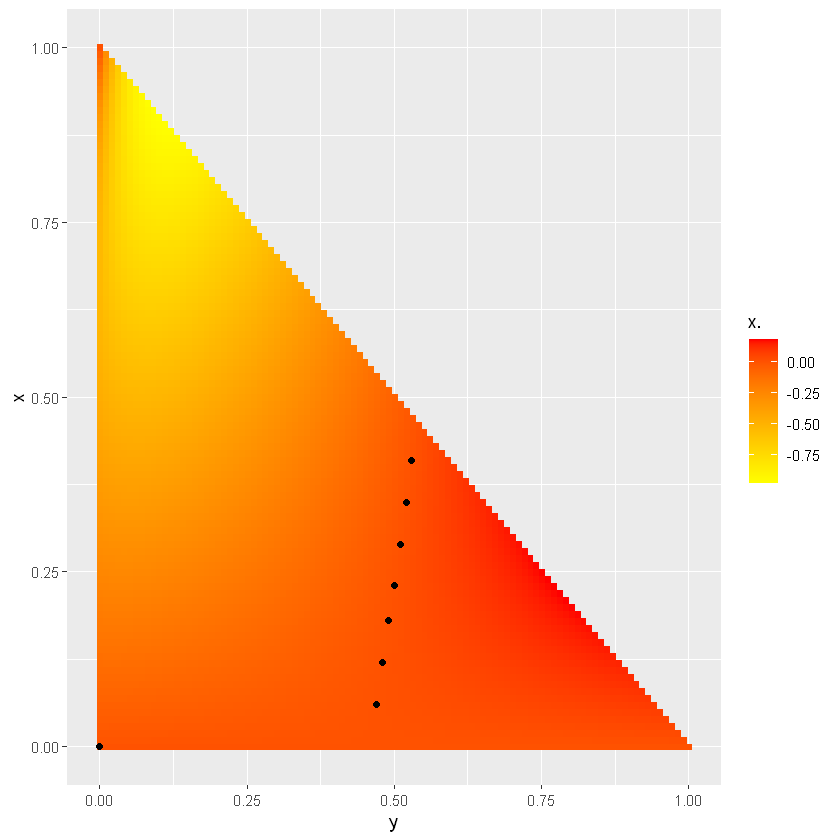

In [75]:
#x与y对xstar的影响？
#.x,y, fill=y.  然后把y.=0的点标记红色
data2<-data1 %>% 
  subset(x0<0) %>% 
  dplyr::select(y,x)

data3<-data1 %>% 
  mutate(x2=c(data2$x,rep(0,nrow(data1)-nrow(data2)))) %>% 
  mutate(y2=c(data2$y,rep(0,nrow(data1)-nrow(data2))))

ggplot(data3,aes(x=y,y=x))+
  scale_fill_gradient(high = "red" , low ="yellow")+
  geom_raster(aes(fill=x.))+
  geom_point(aes(x=y2,y=x2),color="black")

#大片异常点，什么原因？
#如何配色更适合凸显0的分界线？
#如何解释？

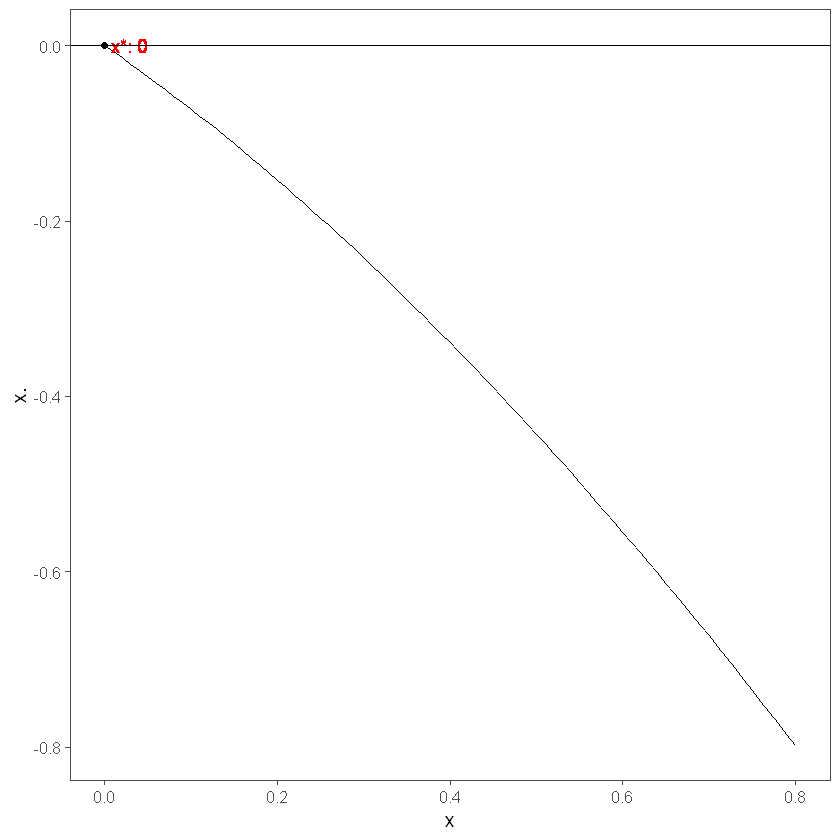

In [73]:
#当y=0.7时
df<-data %>% 
  subset(y==0.2)%>% 
  mutate(x1=c(x.[-1],0)) %>% 
  mutate(x0=x.*x1)#通过前一项与后一项相乘是否小于0，来获取临界点ystar

xstar<-ifelse(sum(df$x[df$x0<0])==0,0,df$x[df$x0<0]+0.005)

ggplot(df,aes(x=x,y=x.))+
  geom_line(color="black",size=0.3)+
  theme_few() +
  geom_point(aes(x=xstar,y=0))+
  geom_text(aes(x=xstar,y=0),label=paste("x*:",xstar),size=4,nudge_y = 0.001,nudge_x = 0.03,color="red")+
  geom_hline(aes(yintercept = 0),size=0.3)+
  labs(x = "x", y = "x.")

In [3]:
#------------------------------#
#--------2.1资源量的影响-------#
#------------------------------#

# #x+y<=1
# data<-data.frame()
# pb <- progress_bar$new(format = "  完成百分比 [:bar] :percent 执行时间 :elapsed:elapsedfull",total = 46, clear = FALSE, width= 60)
# 
# for(M in seq(50,500,10)){
#   pb$tick()
#   for(y in seq(0,1,0.01)){
#     for(x in seq(0,1-y,0.01)){
#       temp<-duplicate_dynamic_xy(y,x,M=M,beta1=4,beta2=2,d=4,N=50,c=1,l=0.5)
#       data<-rbind(data,temp)
#     }
#   }
# }
# 
# fwrite(data,"data_beta1=4_beta2=2.csv",row.names = F)

In [5]:
data <- fread("data_beta1=4_beta2=2.csv")
head(data)

y,x,M,beta1,beta2,d,N,c,l,y.,x.
<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
0,0.00,50,4,2,4,50,1,0.5,0,0.000000000
0,0.01,50,4,2,4,50,1,0.5,0,-0.002492551
0,0.02,50,4,2,4,50,1,0.5,0,-0.005045753
0,0.03,50,4,2,4,50,1,0.5,0,-0.007658696
0,0.04,50,4,2,4,50,1,0.5,0,-0.010330441
0,0.05,50,4,2,4,50,1,0.5,0,-0.013060020


In [6]:
#求ystar
data1<-data %>% 
  mutate(y=round(y,digits=2)) %>% #排序有问题，debug是浮点数的问题#第495行
  mutate(x=round(x,digits=2)) %>%
  arrange(M,x,y) %>% 
  data.table() %>% 
  .[,y1:=c(y.[-1],0),by=c("M","x")] %>% 
  mutate(y0=y.*y1) %>% 
  data.table() %>% 
  .[,ystar:=y[y0<0]-0.005,by=c("M","x")] %>% 
  mutate(ystar=ifelse(is.na(ystar),0,ystar)) %>% #好多NA的问题，是无0,要设置为o
  subset(!is.na(ystar))

head(data1)

y,x,M,beta1,beta2,d,N,c,l,y.,x.,y1,y0,ystar
<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00,0,50,4,2,4,50,1,0.5,0.00000000,0,0.02688523,0.000000000,0.165
0.01,0,50,4,2,4,50,1,0.5,0.02688523,0,0.04781928,0.001285632,0.165
0.02,0,50,4,2,4,50,1,0.5,0.04781928,0,0.06363772,0.003043110,0.165
0.03,0,50,4,2,4,50,1,0.5,0.06363772,0,0.07505120,0.004776087,0.165
0.04,0,50,4,2,4,50,1,0.5,0.07505120,0,0.08266627,0.006204203,0.165
0.05,0,50,4,2,4,50,1,0.5,0.08266627,0,0.08700242,0.007192166,0.165


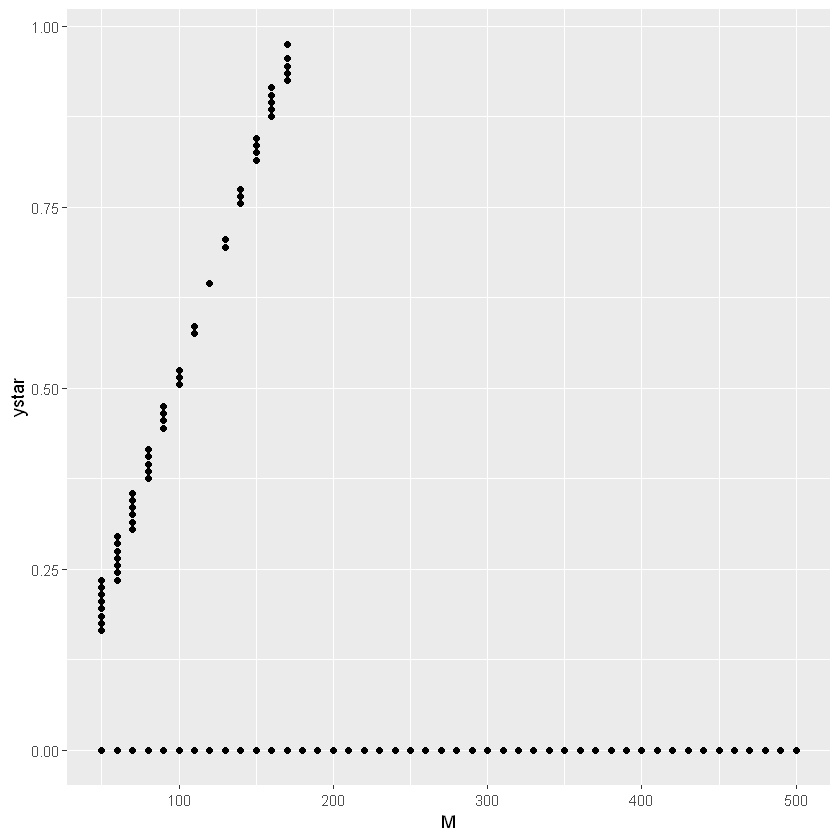

In [7]:
#ystar随M是如何变化的？
ggplot(data1,aes(x=M,y=ystar))+
  geom_point()

#如何解释？

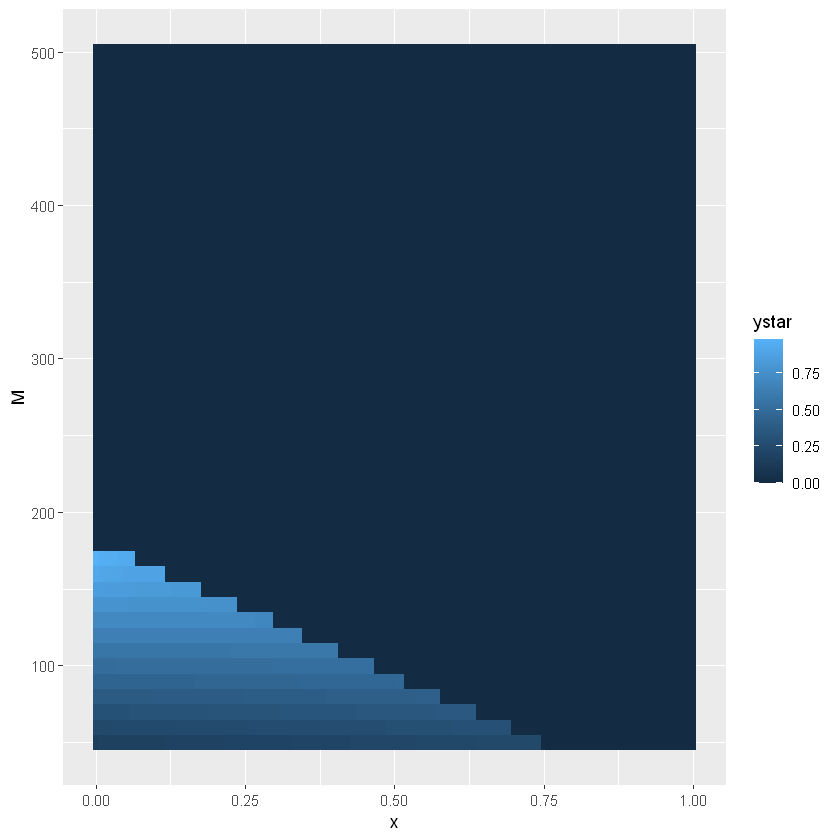

In [8]:
#ystar随M和x是如何变化的？
ggplot(data1,aes(x=x,y=M))+
  geom_raster(aes(fill=ystar))

In [9]:
#求xstar
data2<-data %>% 
  mutate(y=round(y,digits=2)) %>% #排序有问题，debug是浮点数的问题#第495行
  mutate(x=round(x,digits=2)) %>%
  arrange(M,y,x) %>% 
  data.table() %>% 
  .[,x1:=c(x.[-1],0),by=c("M","y")] %>% 
  mutate(x0=x.*x1) %>% 
  data.table() %>% 
  .[,xstar:=x[x0<0]-0.005,by=c("M","y")] %>% 
  mutate(xstar=ifelse(is.na(xstar),0,xstar)) %>% #好多NA的问题，是无0,要设置为o
  subset(!is.na(xstar))

head(data2)

y,x,M,beta1,beta2,d,N,c,l,y.,x.,x1,x0,xstar
<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.00,50,4,2,4,50,1,0.5,0,0.000000000,-0.002492551,0.000000e+00,0
0,0.01,50,4,2,4,50,1,0.5,0,-0.002492551,-0.005045753,1.257680e-05,0
0,0.02,50,4,2,4,50,1,0.5,0,-0.005045753,-0.007658696,3.864389e-05,0
0,0.03,50,4,2,4,50,1,0.5,0,-0.007658696,-0.010330441,7.911770e-05,0
0,0.04,50,4,2,4,50,1,0.5,0,-0.010330441,-0.013060020,1.349158e-04,0
0,0.05,50,4,2,4,50,1,0.5,0,-0.013060020,-0.015846436,2.069548e-04,0


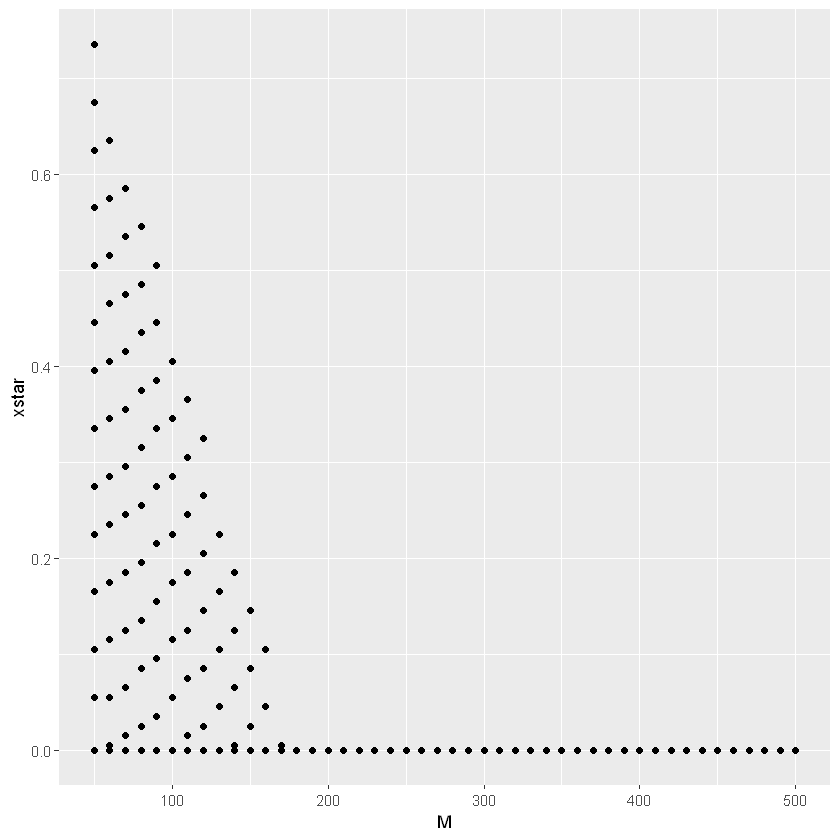

In [10]:
#xstar随M是如何变化的？
ggplot(data2,aes(x=M,y=xstar))+
  geom_point()

In [17]:
24*6000*4000*10^6/1024/1024/8

[1] 68664551

In [ ]:
#xstar随M和x是如何变化的？
ggplot(data2,aes(x=x,y=M))+
  geom_raster(aes(fill=xstar))

In [11]:
#----------------------------#
#--------3.beta1的影响-------#
#----------------------------#

# data<-data.frame()
# pb <- progress_bar$new(format = "  完成百分比 [:bar] :percent 执行时间 :elapsed:elapsedfull",total = 46, clear = FALSE, width= 60)
# 
# for(M in seq(50,500,10)){
#   pb$tick()
#   for(beta1 in c(6,8,10)){
#     for(y in seq(0,1,0.01)){
#       for(x in seq(0,1-y,0.01)){
#         temp<-duplicate_dynamic_xy(y,x,M=M,beta1,beta2=2,d=4,N=50,c=1,l=0.5)
#         data<-rbind(data,temp)
#       }
#     }
#   }
# }
# 
# fwrite(data,"data_beta1=6-8-10_beta2=2.csv",row.names = F)

In [12]:
#求ystar
data<-fread("data_beta1=6-8-10_beta2=2.csv")%>%
    rbind(fread("data_beta1=4_beta2=2.csv")) %>% 
    mutate(y=round(y,digits=2)) %>% #排序有问题，debug是浮点数的问题#第495行
    mutate(x=round(x,digits=2)) %>%
    arrange(M,beta1,y,x) %>% 
    data.table()%>% 
    .[,y1:=c(y.[-1],0),by=c("M","x","beta1")] %>% 
    mutate(y0=y.*y1) %>% 
    data.table() %>% 
    .[,ystar:=y[y0<0]-0.005,by=c("M","x","beta1")] %>% 
    mutate(ystar=ifelse(is.na(ystar),0,ystar)) %>% #好多NA的问题，是无0,要设置为o
    subset(!is.na(ystar))
head(data)

ERROR: Error in fread("data_beta1=6-8-10_beta2=2.csv"): File 'data_beta1=6-8-10_beta2=2.csv' does not exist or is non-readable. getwd()=='F:/Code/R'


In [ ]:
library("plot3D")

In [ ]:
scatter3D(x, y, z, phi = 0, bty = "g",
        pch = 20, cex = 2, ticktype = "detailed")

In [ ]:
#求xstar
data<-fread("data_beta1=6-8-10_beta2=2.csv")%>%
    rbind(fread("data_beta1=4_beta2=2.csv")) %>% 
    mutate(y=round(y,digits=2)) %>% #排序有问题，debug是浮点数的问题#第495行
    mutate(x=round(x,digits=2)) %>%
    arrange(M,beta1,x,y) %>% 
    data.table()%>% 
    .[,x1:=c(x.[-1],0),by=c("M","y","beta1")] %>% 
    mutate(x0=x.*x1) %>% 
    data.table() %>% 
    .[,xstar:=x[x0<0]-0.005,by=c("M","y","beta1")] %>% 
    mutate(xstar=ifelse(is.na(xstar),0,xstar)) %>% #好多NA的问题，是无0,要设置为o
    subset(!is.na(xstar))
head(data)

In [ ]:
#----------------------------#
#--------4.beta2的影响-------#
#----------------------------#
# #用多线程试试
# data<-data.frame()
# pb <- progress_bar$new(format = "  完成百分比 [:bar] :percent 执行时间 :elapsed:elapsedfull",total = 46, clear = FALSE, width= 60)
# 
# for(M in seq(50,500,10)){
#   pb$tick()
#   for(beta2 in 3:7){
#     for(y in seq(0,1,0.01)){
#       for(x in seq(0,1-y,0.01)){
#         temp<-duplicate_dynamic_xy(y,x,M=M,beta1=8,beta2=beta2,d=4,N=50,c=1,l=0.5)
#         data<-rbind(data,temp)
#       }
#     }
#   }
# }
# 
# fwrite(data,"data_beta1=8_beta2=3-4-5-6-7.csv",row.names = F)
